# LSST Filters

This notebook demonstrates the LSST filter set and the fiducial LSST atmosphere. These transmission functions are compared against spectral templates for stars and SNe.


In [1]:
import sys
from pathlib import Path
sys.path.insert(0, '../')

import numpy as np
import sncosmo
from matplotlib import pyplot as plt
from pwv_kpno.defaults import v1_transmission
from scipy.ndimage import gaussian_filter

from snat_sim import plotting
from snat_sim.models import ReferenceStar, SNModel


In [2]:
fig_dir = Path('.') / 'figs' / 'lsst_filters'
fig_dir.mkdir(exist_ok=True, parents=True)


## Baseline Filter Set

The LSST filter set is provided in enough detail that we can separate the hardware and atmospheric contributions. This allows us to add our own customized atmospheric component(s).

In [3]:
def plot_lsst_filters():
    """Plot the response curves for the LSST hardware and filters"""
    
    fig, (left_ax, right_ax) = plt.subplots(1, 2, sharex=True, sharey=True, figsize=(12, 6))

    # Transmissions that are NOT reported on a per band basis
    detector = sncosmo.get_bandpass('lsst_detector')
    lenses = sncosmo.get_bandpass('lsst_lenses')
    mirror = sncosmo.get_bandpass('lsst_mirrors')
    atm = sncosmo.get_bandpass('lsst_atmos_std')
    
    # Plot hardware transmissions on left axis
    left_ax.plot(detector.wave, detector.trans, label='Detector')
    left_ax.plot(lenses.wave, lenses.trans, label='Lenses')
    left_ax.plot(mirror.wave, mirror.trans, label='Mirrors')
    
    # Non hardware goes on the right axis
    right_ax.plot(atm.wave, atm.trans, color='C0', label='LSST Atm.')
    
    # Band specific transmissions
    for i, band_letter in enumerate('ugrizy'):
        band_total = sncosmo.get_bandpass(f'lsst_total_{band_letter}')
        hardware = sncosmo.get_bandpass(f'lsst_hardware_{band_letter}')
        filter_only = sncosmo.get_bandpass(f'lsst_filter_{band_letter}')
        
        left_ax.fill_between(filter_only.wave, filter_only.trans, color=f'C{i}', alpha=.2, label='Filters' if i == 0 else None)
        left_ax.plot(hardware.wave, hardware.trans, color='k', label='All Hardware' if i == 0 else None)
        
        right_ax.plot(hardware.wave, hardware.trans, color='k', label='Hardware' if i == 0 else None)
        right_ax.fill_between(band_total.wave, band_total.trans, alpha=.2, label='Bandpass' if i == 0 else None)
        right_ax.plot(band_total.wave, hardware(band_total.wave) * atm(band_total.wave))
        
    left_ax.set_xlabel(r'Wavelength ($\AA$)')
    left_ax.set_ylabel('Transmission')
    left_ax.set_xlim(3000, 11_000)
    left_ax.set_ylim(0, 1)
    left_ax.set_title('Hardware')
    left_ax.legend(loc='lower right', framealpha=1)
    
    right_ax.set_xlabel(r'Wavelength ($\AA$)')
    right_ax.set_title('Total Response')
    right_ax.legend(loc='upper left', framealpha=1)
    

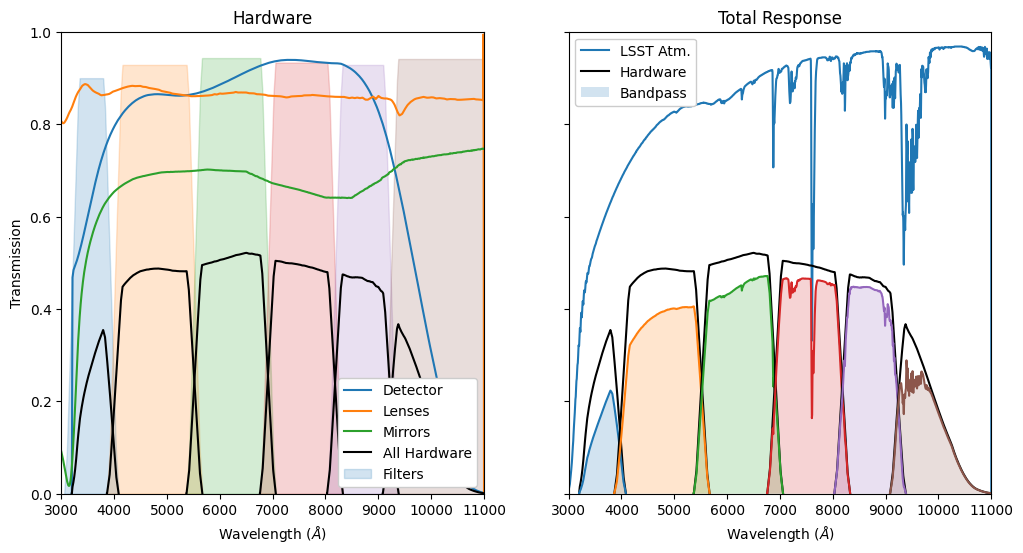

In [4]:
plot_lsst_filters()
plt.savefig(fig_dir / 'filters_and_hardware.pdf')
plt.show()


The atmospheric transmission profile provided by the LSST engineering team includes the entire atmospheric contribution. We instead use a model for PWV transmission only, shown below:

In [5]:
def plot_pwv_scaling():
    """Plot the LSST filter throughputs overlaid with Atm. transmission for three different PWV values"""
    
    
    fig, axes = plt.subplots(3, figsize=(12, 6), sharex=True, sharey=True)
    axes[0].set_xlim(6_000, 10000)
    axes[0].set_ylim(0, 1)
    
    for band_letter in 'ugrizy':
        hardware = sncosmo.get_bandpass(f'lsst_hardware_{band_letter}')
        for i, axis in enumerate(axes):
            axis.fill_between(hardware.wave, hardware.trans, alpha=.5)
    
    wave = np.arange(*axes[0].get_xlim())
    pwv_vals = [1, 4, 10]
    for i, axis in enumerate(axes):
        pwv = pwv_vals[i]
        axis.plot(wave, v1_transmission(pwv, wave), linewidth=.5, label=f'PWV = {pwv} mm')
        
        axis.legend(loc='upper left', framealpha=1)
        axis.set_ylabel('Transmission', fontsize=12)
        
    axes[-1].set_xlabel(r'Wavelength ($\AA$)', fontsize=12)


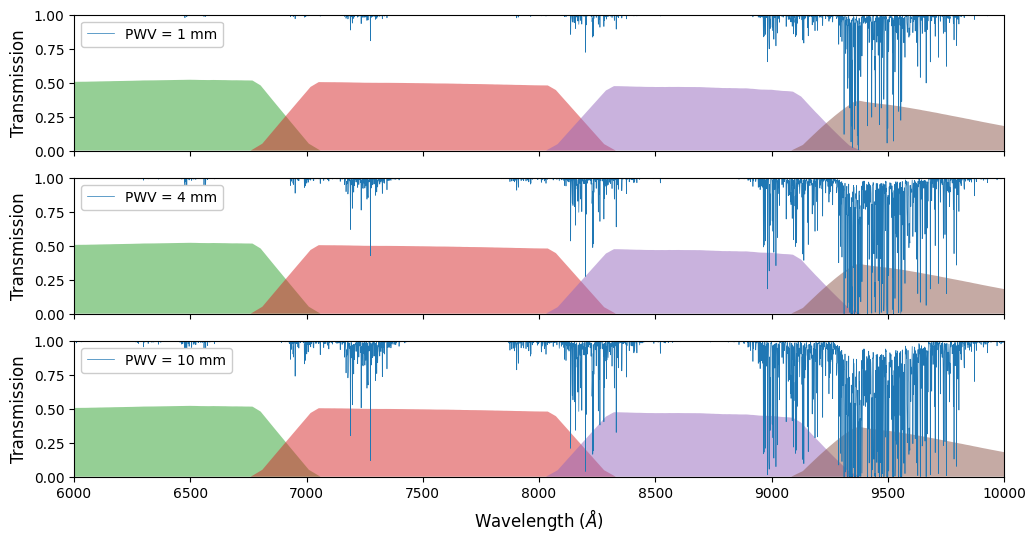

In [6]:
plot_pwv_scaling()
plt.savefig(fig_dir / 'pwv_scaling.pdf')
plt.show()


## The Fiducial ATM

We compare the reddest (largest) PWV absorption feature of the LSST standard atmosphere against the atmospheric model from `pwv_kpno`. We compare the LSST atmosphere against PWV absorption for 4mm PWV binned at a 5 angstrom resolution.

In [7]:
def fit_lsst_atm_continua(deg, *wave_ranges, lsst_atm='lsst_atmos_std'):
    """Fit the LSST atmosphere with a polynomial
    
    Args:
        deg                (int): The degree of the fitted polynomial
        *wave_ranges     (tuple): Start and end wavelengths of regions to fit
        lsst_atm (str, Bandpass): The atmosphere to fit
        
    Returns:
        - A tuple of fit parameters
        - A function representing the fitted polynomial
    """

    # Ensure the lsst_atm variable is a Bandpass object
    lsst_atm = sncosmo.get_bandpass(lsst_atm)
    
    # Fit the LSST transmission over the given wavelength ranges
    wavelengths = np.concatenate([np.arange(*w) for w in wave_ranges])
    fit_params = np.polyfit(wavelengths, lsst_atm(wavelengths), deg)

    return fit_params, np.poly1d(fit_params)


In [8]:
def plot_lsst_atm():
    """Plot the LSST standard atmosphere"""
    
    # Fit the LSST atmospheric continuum (i.e. the non-PWV transmission)
    lsst_atm = sncosmo.get_bandpass('lsst_atmos_std')
    continuum_wavelengths = [(8400, 8850), (10_000, 10_500)]
    fit_params, fit_func = fit_lsst_atm_continua(2, *continuum_wavelengths, lsst_atm=lsst_atm)
    fit_label = fr'{fit_params[0]: .1e} x$^2$ + {fit_params[1]: .1e} x + {fit_params[2]: .2f}'

    fig, (left_ax, right_ax) = plt.subplots(1, 2, sharex=True, sharey=True, figsize=(12, 6))
    
    # Plot fit to the continuum in left axis
    left_ax.plot(lsst_atm.wave, lsst_atm.trans, label='LSST Fiducial Atmosphere')
    left_ax.plot(lsst_atm.wave, fit_func(lsst_atm.wave), label=fit_label)
    for i, wave_range in enumerate(continuum_wavelengths):
        label = 'Continuum' if i == 0 else None
        left_ax.axvspan(*wave_range, color='C3', alpha=.1, label=label)
        
    left_ax.set_xlabel(r'Wavelength ($\AA$)')
    left_ax.set_ylabel('Total Transmission')
    left_ax.set_xlim(8000, 11000)
    left_ax.set_ylim(.5, 1)
    left_ax.legend(loc='lower left', framealpha=1)
    
    # Plot comparison of normalized and modeled absorption feature
    normalized_trans = lsst_atm.trans / fit_func(lsst_atm.wave)
    modeled_trans = v1_transmission(4, lsst_atm.wave, 5)
    
    right_ax.plot(lsst_atm.wave, modeled_trans, color='grey', label='pwv_kpno')
    right_ax.plot(lsst_atm.wave, normalized_trans, label='Normalized LSST')
    
    right_ax.set_xlabel(r'Wavelength ($\AA$)')
    right_ax.set_ylabel('PWV Transmission')
    right_ax.legend(loc='lower left', framealpha=1)


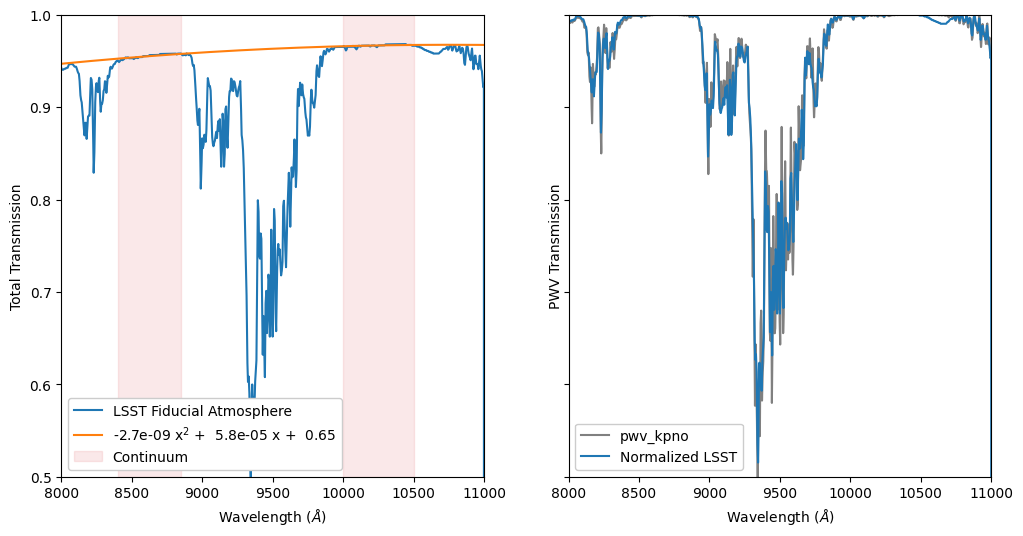

In [9]:
plot_lsst_atm()
plt.savefig(fig_dir / 'atmospheric_continuum_fit.pdf')
plt.show()


A rough minimization shows that our choice of resolution and PWV concentration in the above plot were reasonable. 

In [10]:
from scipy.optimize import minimize

fit_params, fit_func = fit_lsst_atm_continua(2, (8400, 8850), (10_000, 10_500))

lsst_atm = sncosmo.get_bandpass('lsst_atmos_std')
lsst_atm_normalized = sncosmo.Bandpass(
    wave=lsst_atm.wave, 
    trans=lsst_atm.trans / fit_func(lsst_atm.wave)
)


def summed_residuals(x):
    pwv, res = x
    
    wavelengths = np.arange(8400, 10_500)
    modeled_trans = v1_transmission(pwv, wavelengths, res)
    normalized_trans = lsst_atm_normalized(wavelengths)
    stat = np.average(normalized_trans - modeled_trans)
    return abs(stat)


x0 = 4, 5
res = minimize(summed_residuals, x0, bounds=[(2, 10), (1, 10)], tol=.01)
print('Best fit PWV:', res.x[0])
print('Best fit Resolution:', res.x[1])


Best fit PWV: 4.000000000490046
Best fit Resolution: 4.999999802004262


## Stellar Fluxes

We take note of how the stellar flux changes in each band relative to PWV = 0. We rely on stellar spectra from the Göttingen spectral library, as demonstrated below.

In [11]:
def plot_stellar_spectrum(spectype='G2', figsize=(8, 5)):
    """Plot the spectrum of a given spectral type
    
    Args:
        spectype  (str): Type of the spectrum
        figsize (tuple): Size of the created figure
    """

    stellar_spectrum = ReferenceStar(spectype).to_pandas()
    transmission = v1_transmission(4, stellar_spectrum.index)
    
    fig, axis = plt.subplots(figsize=figsize)
    twin_ax = axis.twinx()
    
    ones = np.ones_like(transmission)
    axis.plot(stellar_spectrum.index, stellar_spectrum, color='k', linewidth=.05, label='Stellar SED')
    twin_ax.fill_between(transmission.index, ones, transmission, ones, 'Atmosphere')
    for i, b in enumerate('ugrizy'):
        color = f'C{i + 1}'
        band = sncosmo.get_bandpass(f'lsst_hardware_{b}')
        
        twin_ax.fill_between(band.wave, band.trans, label=f'{b} Band', zorder=0, alpha=.4, color=color)
        twin_ax.plot(band.wave, band.trans, color=color)
        
    axis.set_xlabel(r'Wavelength $\AA$')
    axis.set_ylabel('Flux')
    axis.set_xlim(3000, 11000)
    axis.set_ylim(0)
    axis.legend()
    
    twin_ax.set_ylim(0, 1)
    twin_ax.set_ylabel('Transmission', rotation=-90, labelpad=14)


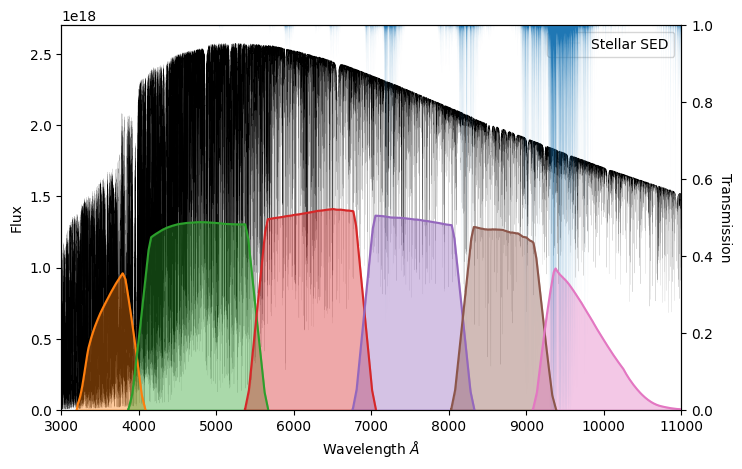

In [12]:
plot_stellar_spectrum()
plt.savefig(fig_dir / 'stellar_spectrum.pdf')


In [13]:
def plot_scale_factor(spectype='G2'):
    """Plot the stellar flux in each band as a fraction of the 
    flux at PWV = 0.
    
    Args:
        spectype (str): Spectral type to calculate scale factor for
    """
    
    fig, axis = plt.subplots()

    ref_df = ReferenceStar(spectype).flux_scaling_dataframe()
    for band in 'ugrizy':
        band_data = ref_df[f'lsst_hardware_{band}_norm']
        axis.plot(ref_df.index, band_data, label=f'{band} Band')

    axis.set_ylabel('Flux Ratio')
    axis.set_xlabel('PWV (mm)')
    axis.set_xlim(0, 15)
    axis.legend()


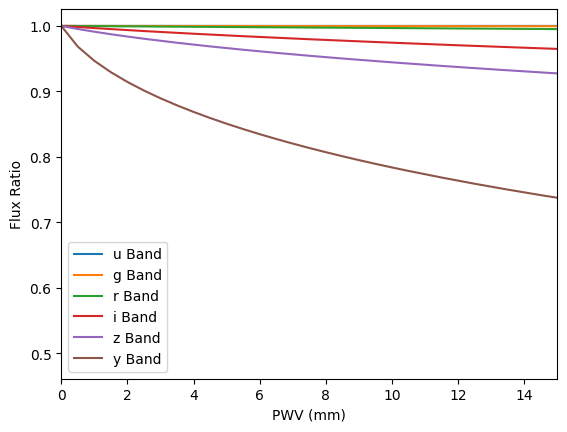

In [14]:
plot_scale_factor()
plt.savefig(fig_dir / 'stellar_scale_factors.pdf')


It is important to rember that stars have very different colors than SNe (as shown by the following plots). Here we bin the stellar spectrum to roughly the same resolution as the SN spectral template.

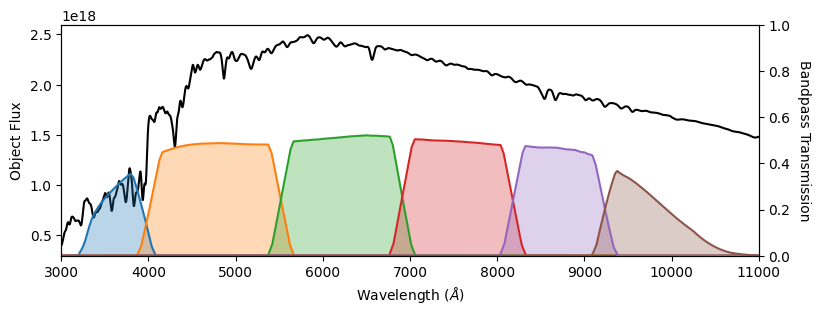

In [15]:
g2_spec = ReferenceStar('G2').to_pandas()

filtered_data = gaussian_filter(g2_spec, 2000)
plotting.plot_spectrum(g2_spec.index, filtered_data, hardware_only=True)
plt.xlim(3000, 11000)

plt.savefig(fig_dir / 'g2_template_over_filters.pdf')


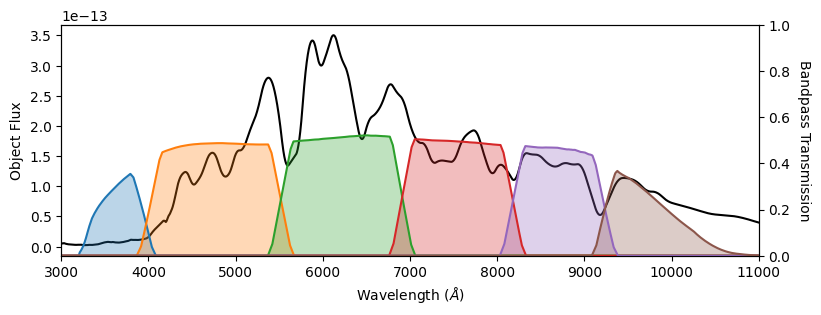

In [16]:
sn_model = SNModel('salt2-extended')
sn_model.set(z=.5)
sn_wave = np.arange(3000, 12000)
sn_flux = sn_model.flux(0, sn_wave)
plotting.plot_spectrum(sn_wave, sn_flux, hardware_only=True)
plt.xlim(3000, 11000)

plt.savefig(fig_dir / 'sn_template_over_filters.pdf')
